<h1, align=center>Building a Word2Vec Model with Twitter Data</h1>

<h3, align = center>The content was written by:</h3>
<h3, align = center>[Jorge A Castañón](https://github.com/castanan/w2v)</h3>
<h4, align=center>_The code used in this tutorial is adapted from Jorge A Castañón's GitHub page._</h4>

### Blog: https://ibm.biz/word2vec

<hr>

# Step 1: Download Tweets

Let's download the corpus of tweets, `tweets.gz` (118 Mb)

# Step 2: Download File with Keywords

# Import Python and Pyspark Packages

In [1]:
import os, sys, codecs, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.display import display

from pyspark.mllib.feature import Word2Vec
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import PCA

# Step 3: Function to Filter Tweets and Train Word2Vec

In [3]:
def readFilters(filterpath):
    filters = set()
    f = open(filterpath, 'r')
    for line in f:
        line = codecs.decode(line, "utf-8")
        line = line.strip()
        if len(line) == 0: continue
        filters.add(line.lower())
    f.close()
    return filters

def process(filters):
    def realProcess(line):
        key = 'text'
        try:
            t = json.loads(line)
            if key not in t or t['lang']!='en': return None
            value = t[key].lower()
            # match with filters
            found = False
            for ff in filters:
                if ff in value:
                    return t
                    break
        except Exception as e:
            return None
        return None
    return realProcess

def filterAndTrainWord2vec(datapath,filterpath,word):
    
    filters = readFilters(filterpath) 
    data = sc.textFile(datapath)
    totaltw = data.count()

    # the next line filters tweets of interest
    tweets = data.map(process(filters)).filter(lambda x: x != None).map(lambda t: t['text'])
    twcount = tweets.count()
    
    # the next line cleans unwanted characters and transform text to lower case
    tweets = tweets.map(lambda x: x.replace(";"," ").replace(":"," ").replace('"',' ').replace('-',' ').replace(',',' ').replace('.',' ').lower())
    # the next line breaks tweets into words
    tweets = tweets.map(lambda row: row.split(" ")) 
    
    ## train Word2vec
    word2vec = Word2Vec()
    model = word2vec.fit(tweets) 

    ## Get the list of words in the w2v matrix
    vocabsize = 10000
    any_word = word
    tmp_list = model.findSynonyms(any_word, vocabsize-1) #setting my vocabulary size to at most 100K words
    list_words = []
    for l in tmp_list:
        list_words.append(l[0])
    list_words.append(any_word)

    nwords = len(list_words)
    nfeatures = model.transform(any_word).array.shape[0]
    
    ## Construct the feature matrix, each row is asociated to each word in list_words
    feature_matrix = [] 
    for word in list_words:
        feature_matrix.append(model.transform(word).array)
    
    ## save W2V matrix and the list of words 
    np.save('/Users/jorgecastanon/Documents/github/w2v/mllib-scripts/myW2Vmatrix.npy',feature_matrix)
    np.save('/Users/jorgecastanon/Documents/github/w2v/mllib-scripts/myWordList.npy',list_words)
    
    print "================================================="
    print "Number of total tweets processed: ", totaltw
    print "================================================="
    print "Number of filtered tweets used: ", twcount
    print "================================================="
    print "Number of words in the model:", nwords
    print "================================================="
    print "Number of features per word: ", nfeatures
    print "================================================="

    return nwords

# Step 4: Cluster Words with K-means

In [4]:
def clusterWords(K):
    
    Feat = np.load('/Users/jorgecastanon/Documents/github/w2v/mllib-scripts/myW2Vmatrix.npy')    # reads model generated by Word2Vec
    words = np.load('/Users/jorgecastanon/Documents/github/w2v/mllib-scripts/myWordList.npy')    # reads list of words
    Featshape = Feat.shape
    
    Feat = sc.parallelize(Feat)

    ## K-means clustering with Spark  
    maxiters=100
    clusters = KMeans.train(Feat, k = K, maxIterations = maxiters) 
    
    ## Getting Cluster Labels for each Word and saving to a numpy file
    labels =  Feat.map(lambda point: clusters.predict(point)) # add labels to each vector (word)
    list_labels = labels.collect()
    np.save('/Users/jorgecastanon/Documents/github/w2v/mllib-scripts/myClusters.npy',list_labels)
    
    print "="*70
    print "Size of the Word2vec matrix (words, features) is: ", Featshape 
    print "="*70
    print "Number of clusters used: ", K
    print "="*70


# Step 5: Function to Find Similar Words

In [5]:
def findSimilarWords(word, nwords = 20):
    
    Feat = np.load('/Users/jorgecastanon/Documents/github/w2v/mllib-scripts/myW2Vmatrix.npy')  
    words = np.load('/Users/jorgecastanon/Documents/github/w2v/mllib-scripts/myWordList.npy')
    labels = np.load('/Users/jorgecastanon/Documents/github/w2v/mllib-scripts/myClusters.npy')
    
    Nw = words.shape[0]                # total number of words
    ind_star = np.where(word == words) # find index of the chosen word
    wstar = Feat[ind_star,:][0][0]     # vector corresponding to the chosen 'word'
    nwstar = math.sqrt(np.dot(wstar,wstar)) # norm of vector corresponding to the chosen 'word'

    dist = np.zeros(Nw) # initialize vector of distances
    i = 0
    for w in Feat: # loop to compute cosine distances 
        den = math.sqrt(np.dot(w,w))*nwstar  # compute denominator of cosine distance
        dist[i] = abs( np.dot(wstar,w) ) / den   # compute cosine distance to each word
        i = i + 1

    indexes = np.argpartition(dist,-(nwords+1))[-(nwords+1):]
    di = []
    for j in range(nwords+1):
        di.append(( words[indexes[j]], dist[indexes[j]], labels[indexes[j]] ) )

    result = pd.DataFrame(di, columns = ["word","similarity","cluster"])
    return result.iloc[::-1] # order results from closest to 

# Step 6: Function to Visualize Words Using PCA

In [6]:
def visualizeWords(maxWordsVis):

    Feat = np.load('/Users/jorgecastanon/Documents/github/w2v/mllib-scripts/myW2Vmatrix.npy')  
    words = np.load('/Users/jorgecastanon/Documents/github/w2v/mllib-scripts/myWordList.npy')
    # to rdd, avoid this with big matrices by reading them directly from hdfs
    Feat = sc.parallelize(Feat) 
    Feat = Feat.map(lambda vec: (Vectors.dense(vec),))
    # to dataframe
    dfFeat = sqlContext.createDataFrame(Feat,["features"])
    
    ## PCA to project Feature matrix to 2 dimensions
    numComponents = 3
    pca = PCA(k = numComponents, inputCol = "features", outputCol = "pcaFeatures")
    model = pca.fit(dfFeat)
    dfComp = model.transform(dfFeat).select("pcaFeatures")
    # get the first two components to lists to be plotted
    compX = dfComp.map(lambda vec: vec[0][0]).take(maxWordsVis)
    compY = dfComp.map(lambda vec: vec[0][1]).take(maxWordsVis)
    compZ = dfComp.map(lambda vec: vec[0][2]).take(maxWordsVis)
    return compX, compY, compZ, words

# Step 7: Compute and Show Results

### Filter Tweets and Train Word2Vec

In [7]:
pathToKeywords = '/Users/jorgecastanon/Documents/github/w2v/data/filter.txt'
pathToTweets = '/Users/jorgecastanon/Documents/github/w2v/data/tweets.gz'
word = 'christmas'
numWords = filterAndTrainWord2vec(pathToTweets,pathToKeywords,word)

Number of total tweets processed:  239082
Number of filtered tweets used:  23481
Number of words in the model: 5648
Number of features per word:  100


### Cluster Words with K-means

In [8]:
K = int(math.floor(math.sqrt(float(numWords)/2)))
         # K ~ sqrt(n/2) this is a rule of thumb for choosing K,
         # where n is the number of words in the model
         # feel free to choose K with a fancier algorithm

clusterWords(K)

Size of the Word2vec matrix (words, features) is:  (5648, 100)
Number of clusters used:  53


### Find Similar Words and Clusters

In [9]:
res = findSimilarWords(word = 'christmas', nwords = 10)
display(res)

,word,similarity,cluster
10,christmas,1.000000,26
9,xmas,0.631012,26
8,christmas',0.624468,14
7,christmas!,0.575984,26
6,eve,0.558380,35
5,eve!!,0.484607,17
4,eve!!!!!,0.479811,17
3,🎅🎄🎁,0.473878,17
2,tomorrow,0.473584,32
1,😍😍😍,0.469500,17


### Use PCA to Visualize Words

In [10]:
maxWordsVis = 15
compX, compY, compZ, words = visualizeWords(maxWordsVis)

/Users/jorgecastanon/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


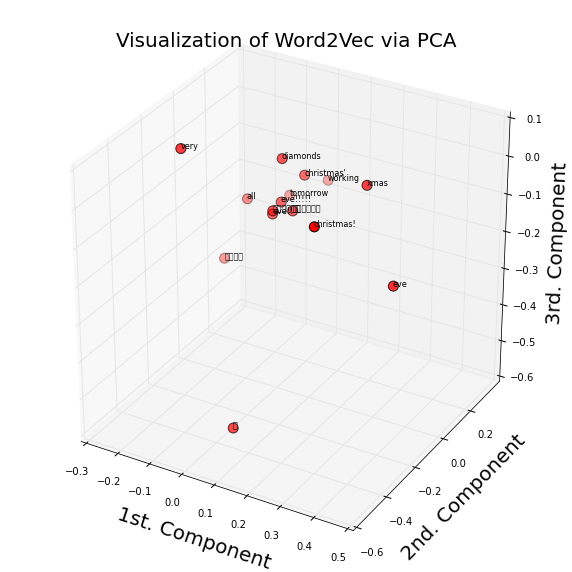

In [11]:
%matplotlib inline
fs=20 #fontsize
w = words[0:maxWordsVis]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

height = 10
width = 10
fig.set_size_inches(width, height)

ax.scatter(compX, compY, compZ, color='red', s=100, marker='o', edgecolors='black')
for i, txt in enumerate(w):
    ax.text(compX[i],compY[i],compZ[i], '%s' % (txt), size=8, zorder=1, color='k')
ax.set_xlabel('1st. Component', fontsize=fs)
ax.set_ylabel('2nd. Component', fontsize=fs)
ax.set_zlabel('3rd. Component', fontsize=fs)
ax.set_title('Visualization of Word2Vec via PCA', fontsize=fs)
ax.grid(True)
plt.show()